In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp
from statsmodels.stats.multitest import multipletests

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Helper Functions
def partial_eta_squared(aov):
    """Calculate partial eta-squared for ANOVA results."""
    aov = aov.copy()
    aov['pes'] = (aov['Num DF'] * aov['F Value']) / (aov['Num DF'] * aov['F Value'] + aov['Den DF'])
    return aov

def analyze_roi_data(data, experiment='exp1'):
    """Analyze ROI data with multiple comparison correction."""
    results = {}
    all_tests = []
    
    if experiment == 'exp1':
        conditions = ['object', 'scramble']
        rois = ['LO', 'pIPS']
    else:
        conditions = ['tool', 'nontool']
        rois = ['PFS', 'aIPS', 'LO', 'pIPS']
        
    for roi in rois:
        for hemi in ['left', 'right']:
            roi_data = data[(data['roi'] == roi) & (data['hemi'] == hemi)]
            cond1_data = roi_data[roi_data['cond'] == conditions[0]]['mean_act'].values
            cond2_data = roi_data[roi_data['cond'] == conditions[1]]['mean_act'].values
            
            # Calculate statistics
            t_stat, p_val = ttest_rel(cond1_data, cond2_data)
            mean_diff = np.mean(cond1_data - cond2_data)
            se_diff = np.std(cond1_data - cond2_data) / np.sqrt(len(cond1_data))
            d = mean_diff / np.sqrt((np.std(cond1_data)**2 + np.std(cond2_data)**2) / 2)
            
            # Store results
            all_tests.append({
                'roi': f'{hemi}_{roi}',
                'p_value': p_val,
                't_stat': t_stat,
                'mean_diff': mean_diff,
                'se': se_diff,
                'cohens_d': d,
                'n': len(cond1_data),
                f'mean_{conditions[0]}': np.mean(cond1_data),
                f'mean_{conditions[1]}': np.mean(cond2_data)
            })
    
    # Apply Holm-Bonferroni correction
    p_values = [test['p_value'] for test in all_tests]
    _, p_corrected, _, _ = multipletests(p_values, method='holm')
    
    # Update results with corrected p-values
    for test, p_corr in zip(all_tests, p_corrected):
        results[test['roi']] = test
        results[test['roi']]['p_corrected'] = p_corr
    
    return results

def run_rmanova(data, factors):
    """Run repeated measures ANOVA with effect sizes."""
    aov = AnovaRM(data=data, 
                  depvar='mean_act',
                  subject='sub',
                  within=factors).fit()
    
    aov_table = partial_eta_squared(aov.anova_table)
    return aov_table

In [4]:
# Load Data
# Experiment 1
exp1_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/selectivity/selectivity_summary.csv")

filtered_exp1 = exp1_results[(exp1_results['group'] == 'control') & 
                            (exp1_results['roi'].isin(['LO', 'pIPS'])) &
                            (exp1_results['sub'] != 'sub-084')]

# Experiment 2
exp2_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/tools/selectivity/selectivity_summarytoolloc.csv")
filtered_exp2 = exp2_results[exp2_results['sub'].str.contains('spaceloc')]

ROI Analysis

In [4]:
# Experiment 1 ROI Analysis
# Full ANOVA
exp1_anova = run_rmanova(filtered_exp1, ['roi', 'hemi', 'cond'])
print("Experiment 1 ANOVA Results:")
print(exp1_anova)

# ROI Analysis
exp1_roi_results = analyze_roi_data(filtered_exp1, 'exp1')
print("\nExperiment 1 ROI Results:")
for roi, stats in exp1_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")

Experiment 1 ANOVA Results:
                  F Value  Num DF  Den DF        Pr > F       pes
roi             39.763898     1.0    17.0  7.897722e-06  0.700514
hemi            10.301246     1.0    17.0  5.140748e-03  0.377318
cond            55.387486     1.0    17.0  9.623988e-07  0.765153
roi:hemi         2.803147     1.0    17.0  1.123766e-01  0.141551
roi:cond       108.745714     1.0    17.0  8.346158e-09  0.864807
hemi:cond        2.746805     1.0    17.0  1.157867e-01  0.139101
roi:hemi:cond    0.056390     1.0    17.0  8.151334e-01  0.003306


NameError: name 'ttest_rel' is not defined

In [5]:
# Experiment 2 ROI Analysis
# Full ANOVA
exp2_anova = run_rmanova(filtered_exp2, ['roi', 'hemi', 'cond'])
print("Experiment 2 ANOVA Results:")
print(exp2_anova)

# ROI Analysis
exp2_roi_results = analyze_roi_data(filtered_exp2, 'exp2')
print("\nExperiment 2 ROI Results:")
for roi, stats in exp2_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")



Experiment 2 ANOVA Results:
                 F Value  Num DF  Den DF        Pr > F       pes
roi            69.788835     3.0    51.0  4.595074e-18  0.804122
hemi           25.586962     1.0    17.0  9.700100e-05  0.600817
cond            1.697378     1.0    17.0  2.100038e-01  0.090782
roi:hemi        1.617712     3.0    51.0  1.967325e-01  0.086891
roi:cond       23.018004     3.0    51.0  1.468259e-09  0.575191
hemi:cond      15.531839     1.0    17.0  1.053597e-03  0.477435
roi:hemi:cond   1.616753     3.0    51.0  1.969531e-01  0.086844


NameError: name 'ttest_rel' is not defined

FC Connectivity

In [ ]:
# Experiment 1 FC Analysis
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# Load data
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
fc_data = data_df[data_df['analysis'] == 'fc']

# 1. Test if connections are significantly different from zero
all_tests = []

for name, group in fc_data.groupby(['seed_hemisphere', 'target_hemisphere']):
    seed_hemi, target_hemi = name
    conn_values = group['mean_activation'].values
    
    # One-sample Wilcoxon signed-rank test against zero
    w_stat, p_val = wilcoxon(conn_values)
    
    all_tests.append({
        'connection': f"{seed_hemi} to {target_hemi}",
        'p_val': p_val,
        'w_stat': w_stat,
        'mean': np.mean(conn_values),
        'sem': np.std(conn_values, ddof=1) / np.sqrt(len(conn_values))
    })
    
    print(f"\n{seed_hemi} to {target_hemi}:")
    print(f"Mean = {np.mean(conn_values):.4f} ± {np.std(conn_values, ddof=1) / np.sqrt(len(conn_values)):.4f}")
    print(f"W = {w_stat:.1f}, p = {p_val:.6f}")

# Apply Holm-Bonferroni correction
p_values = [test['p_val'] for test in all_tests]
_, p_corrected = multipletests(p_values, method='holm')[:2]

print("\nHolm-Bonferroni corrected results:")
for i, test in enumerate(all_tests):
    print(f"{test['connection']}: p = {p_corrected[i]:.6f}")

# 2. Compare ipsilateral vs contralateral connections
# Define ipsilateral connections
ipsi = fc_data[
    ((fc_data['seed_hemisphere'] == 'left') & (fc_data['target_hemisphere'] == 'left')) |
    ((fc_data['seed_hemisphere'] == 'right') & (fc_data['target_hemisphere'] == 'right'))
]['mean_activation']

# Define contralateral connections
contra = fc_data[
    ((fc_data['seed_hemisphere'] == 'left') & (fc_data['target_hemisphere'] == 'right')) |
    ((fc_data['seed_hemisphere'] == 'right') & (fc_data['target_hemisphere'] == 'left'))
]['mean_activation']

# Use paired Wilcoxon test
w_stat, p_val = wilcoxon(ipsi, contra)

print(f"\nIpsilateral vs Contralateral:")
print(f"Mean Ipsilateral = {np.mean(ipsi):.4f} ± {np.std(ipsi, ddof=1) / np.sqrt(len(ipsi)):.4f}")
print(f"Mean Contralateral = {np.mean(contra):.4f} ± {np.std(contra, ddof=1) / np.sqrt(len(contra)):.4f}")
print(f"W = {w_stat:.1f}, p = {p_val:.6f}")

# Add this test to the multiple comparison correction
all_tests.append({
    'connection': "Ipsilateral vs Contralateral",
    'p_val': p_val
})

# Run Holm-Bonferroni on all tests together
all_p_values = [test['p_val'] for test in all_tests]
_, all_p_corrected = multipletests(all_p_values, method='holm')[:2]

# Get the corrected p-value for the ipsi vs contra test (last one added)
ipsi_contra_corrected_p = all_p_corrected[-1]
print(f"Holm-Bonferroni corrected p = {ipsi_contra_corrected_p:.6f}")


left to left:
Mean = 0.1833 ± 0.0145
W = 0.0, p = 0.000004

left to right:
Mean = 0.1637 ± 0.0133
W = 0.0, p = 0.000004

right to left:
Mean = 0.1635 ± 0.0137
W = 0.0, p = 0.000004

right to right:
Mean = 0.1728 ± 0.0135
W = 0.0, p = 0.000004

Holm-Bonferroni corrected results:
left to left: p = 0.000015
left to right: p = 0.000015
right to left: p = 0.000015
right to right: p = 0.000015

Ipsilateral vs Contralateral:
Mean Ipsilateral = 0.1781 ± 0.0098
Mean Contralateral = 0.1636 ± 0.0094
W = 188.0, p = 0.007252
Holm-Bonferroni corrected p = 0.007252


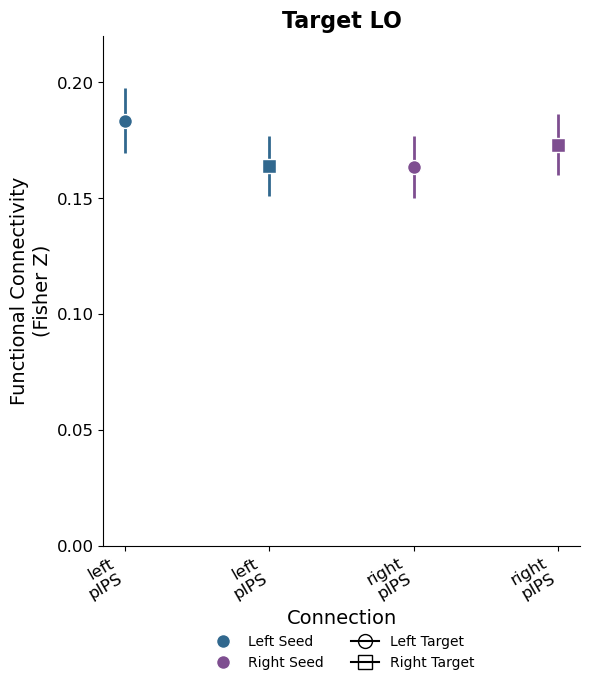

In [ ]:
# Experiment 1 FC Plot
import matplotlib.pyplot as plt
import numpy as np

def create_fc_plot(fc_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space at bottom for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = fc_data[
                (fc_data['seed_hemisphere'] == seed_hemi) &
                (fc_data['target_hemisphere'] == target_hemi)
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=0, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('Functional Connectivity\n(Fisher Z)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    plt.title('Target LO', fontsize=16, fontweight='bold')
    
    # Set y-axis minimum to 0 and fewer ticks
    ax.set_ylim(bottom=0, top=0.22)
    ax.set_yticks(np.arange(0, 0.21, 0.05))  # Set ticks at 0, 0.05, 0.10, 0.15, 0.20
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_fc_plot(fc_data)
plt.show()

In [ ]:
# Experiment 2 FC Analysis

In [ ]:
# Experiment 2 FC Plot

PPI Connectivity

In [ ]:
# Experiment 1 PPI Analysis
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Load data
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
ppi_data = data_df[data_df['analysis'] == 'ppi']

print("PPI Analysis Results:")
print("=" * 50)

# 1. Test if connections are significantly different from zero
all_tests = []

for name, group in ppi_data.groupby(['seed_hemisphere', 'target_hemisphere']):
    seed_hemi, target_hemi = name
    conn_values = group['mean_activation'].values
    
    # One-sample Wilcoxon signed-rank test against zero
    w_stat, p_val = wilcoxon(conn_values)
    
    # Calculate effect size (Cohen's d for one-sample)
    d = np.mean(conn_values) / (np.std(conn_values, ddof=1) + 1e-10)
    
    all_tests.append({
        'connection': f"{seed_hemi} to {target_hemi}",
        'p_val': p_val,
        'w_stat': w_stat,
        'd': d,
        'mean': np.mean(conn_values),
        'sem': np.std(conn_values, ddof=1) / np.sqrt(len(conn_values))
    })
    
    print(f"\n{seed_hemi} to {target_hemi}:")
    print(f"Mean = {np.mean(conn_values):.4f} ± {np.std(conn_values, ddof=1) / np.sqrt(len(conn_values)):.4f}")
    print(f"W = {w_stat:.1f}, p = {p_val:.6f}, d = {d:.3f}")

# Apply Holm-Bonferroni correction
p_values = [test['p_val'] for test in all_tests]
_, p_corrected = multipletests(p_values, method='holm')[:2]

print("\nHolm-Bonferroni corrected results:")
for i, test in enumerate(all_tests):
    print(f"{test['connection']}: p = {p_corrected[i]:.6f}")
    print(f"  SIGNIFICANT" if p_corrected[i] < 0.05 else "  Not significant")

# 2. Compare ipsilateral vs contralateral connections
# Define ipsilateral connections
ipsi = ppi_data[
    ((ppi_data['seed_hemisphere'] == 'left') & (ppi_data['target_hemisphere'] == 'left')) |
    ((ppi_data['seed_hemisphere'] == 'right') & (ppi_data['target_hemisphere'] == 'right'))
]['mean_activation']

# Define contralateral connections
contra = ppi_data[
    ((ppi_data['seed_hemisphere'] == 'left') & (ppi_data['target_hemisphere'] == 'right')) |
    ((ppi_data['seed_hemisphere'] == 'right') & (ppi_data['target_hemisphere'] == 'left'))
]['mean_activation']

# Use paired Wilcoxon test
w_stat, p_val = wilcoxon(ipsi, contra)

# Calculate effect size (Cohen's d for paired samples)
diff = ipsi.values - contra.values
d = np.mean(diff) / (np.std(diff, ddof=1) + 1e-10)

print(f"\nIpsilateral vs Contralateral:")
print(f"Mean Ipsilateral = {np.mean(ipsi):.4f} ± {np.std(ipsi, ddof=1) / np.sqrt(len(ipsi)):.4f}")
print(f"Mean Contralateral = {np.mean(contra):.4f} ± {np.std(contra, ddof=1) / np.sqrt(len(contra)):.4f}")
print(f"W = {w_stat:.1f}, p = {p_val:.6f}, d = {d:.3f}")

# Add this test to the multiple comparison correction
all_tests.append({
    'connection': "Ipsilateral vs Contralateral",
    'p_val': p_val,
    'w_stat': w_stat,
    'd': d
})

# Run Holm-Bonferroni on all tests together
all_p_values = [test['p_val'] for test in all_tests]
_, all_p_corrected = multipletests(all_p_values, method='holm')[:2]

# Get the corrected p-value for the ipsi vs contra test (last one added)
ipsi_contra_corrected_p = all_p_corrected[-1]
print(f"Holm-Bonferroni corrected p = {ipsi_contra_corrected_p:.6f}")
print(f"  SIGNIFICANT" if ipsi_contra_corrected_p < 0.05 else "  Not significant")

# 3. Left vs Right comparisons
print("\n3. Left vs Right seed comparisons:")

# Left vs Right pIPS seeds
left_pips = ppi_data[ppi_data['seed_hemisphere'] == 'left']['mean_activation']
right_pips = ppi_data[ppi_data['seed_hemisphere'] == 'right']['mean_activation']
w_stat_seed, p_val_seed = wilcoxon(left_pips, right_pips)

# Calculate effect size
diff_seed = left_pips.values - right_pips.values
d_seed = np.mean(diff_seed) / (np.std(diff_seed, ddof=1) + 1e-10)

print(f"\nLeft vs Right pIPS seeds:")
print(f"Mean Left = {np.mean(left_pips):.4f} ± {np.std(left_pips, ddof=1) / np.sqrt(len(left_pips)):.4f}")
print(f"Mean Right = {np.mean(right_pips):.4f} ± {np.std(right_pips, ddof=1) / np.sqrt(len(right_pips)):.4f}")
print(f"W = {w_stat_seed:.1f}, p = {p_val_seed:.6f}, d = {d_seed:.3f}")

# Left vs Right LO targets
left_lo = ppi_data[ppi_data['target_hemisphere'] == 'left']['mean_activation']
right_lo = ppi_data[ppi_data['target_hemisphere'] == 'right']['mean_activation']
w_stat_target, p_val_target = wilcoxon(left_lo, right_lo)

# Calculate effect size
diff_target = left_lo.values - right_lo.values
d_target = np.mean(diff_target) / (np.std(diff_target, ddof=1) + 1e-10)

print(f"\nLeft vs Right LO targets:")
print(f"Mean Left = {np.mean(left_lo):.4f} ± {np.std(left_lo, ddof=1) / np.sqrt(len(left_lo)):.4f}")
print(f"Mean Right = {np.mean(right_lo):.4f} ± {np.std(right_lo, ddof=1) / np.sqrt(len(right_lo)):.4f}")
print(f"W = {w_stat_target:.1f}, p = {p_val_target:.6f}, d = {d_target:.3f}")

# Add these tests to the correction
all_tests.append({
    'connection': "Left vs Right pIPS seeds",
    'p_val': p_val_seed,
    'w_stat': w_stat_seed,
    'd': d_seed
})

all_tests.append({
    'connection': "Left vs Right LO targets",
    'p_val': p_val_target,
    'w_stat': w_stat_target,
    'd': d_target
})

# Final correction for all tests
final_p_values = [test['p_val'] for test in all_tests]
_, final_p_corrected = multipletests(final_p_values, method='holm')[:2]

print("\nFinal Holm-Bonferroni corrections:")
for i, test in enumerate(all_tests):
    if i >= len(all_tests) - 3:  # Only show the last 3 tests (ipsi vs contra, left vs right seed, left vs right target)
        print(f"{test['connection']}: corrected p = {final_p_corrected[i]:.6f}")
        print(f"  SIGNIFICANT" if final_p_corrected[i] < 0.05 else "  Not significant")

PPI Analysis Results:

left to left:
Mean = 0.0351 ± 0.0062
W = 3.0, p = 0.000019, d = 1.305

left to right:
Mean = 0.0310 ± 0.0063
W = 12.0, p = 0.000267, d = 1.125

right to left:
Mean = 0.0279 ± 0.0058
W = 13.0, p = 0.000336, d = 1.107

right to right:
Mean = 0.0229 ± 0.0054
W = 20.0, p = 0.001411, d = 0.977

Holm-Bonferroni corrected results:
left to left: p = 0.000076
  SIGNIFICANT
left to right: p = 0.000801
  SIGNIFICANT
right to left: p = 0.000801
  SIGNIFICANT
right to right: p = 0.001411
  SIGNIFICANT

Ipsilateral vs Contralateral:
Mean Ipsilateral = 0.0290 ± 0.0042
Mean Contralateral = 0.0294 ± 0.0042
W = 357.0, p = 0.852178, d = -0.040
Holm-Bonferroni corrected p = 0.852178
  Not significant

3. Left vs Right seed comparisons:

Left vs Right pIPS seeds:
Mean Left = 0.0331 ± 0.0044
Mean Right = 0.0254 ± 0.0039
W = 183.0, p = 0.005714, d = 0.413

Left vs Right LO targets:
Mean Left = 0.0315 ± 0.0042
Mean Right = 0.0269 ± 0.0041
W = 208.0, p = 0.017571, d = 0.452

Final Holm-B

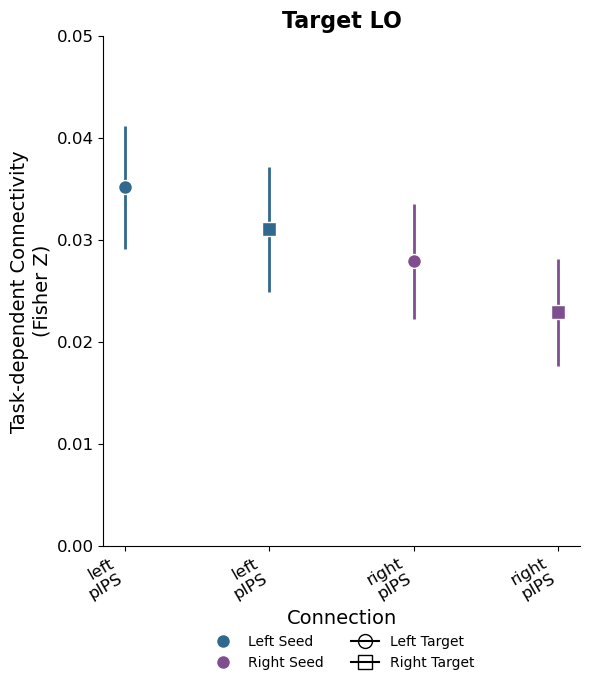

In [ ]:
# Experiment 1 PPI Plot
import numpy as np

def create_ppi_plot(ppi_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = ppi_data[
                (ppi_data['seed_hemisphere'] == seed_hemi) &
                (ppi_data['target_hemisphere'] == target_hemi) &
                (ppi_data['analysis'] == 'ppi')
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=0, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('Task-dependent Connectivity\n(Fisher Z)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    plt.title('Target LO', fontsize=16, fontweight='bold')
    
    # Set y-axis scale with tighter limits
    # Add just a bit of padding above and below the data
    data_range = max(means) - min(means)
    padding = data_range * 0.1  # 10% padding
    ymin = max(-0.05, min(means) - padding)  # Don't go below -0.05 if data doesn't warrant it
    ymax = max(means) + padding
    
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(np.floor(ymin*20)/20, ymax+0.02, 0.01))  # Ticks every 0.05
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_ppi_plot(data_df)
plt.show()

In [ ]:
# Experiment 2 PPI analysis
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# Define paths
output_dir = '/user_data/csimmon2/git_repos/ptoc/tools'

# Read both conditions
tools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_tools.csv")
nontools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_nontools.csv")

# Add condition column to each
tools_df['condition'] = 'Tools'
nontools_df['condition'] = 'Nontools'

# Combine dataframes
df = pd.concat([tools_df, nontools_df])

# Filter out LO seeds and keep only LO targets
df = df[~df['seed_roi'].isin(['LO'])]
df = df[df['target_roi'] == 'LO']

# Analyze each condition separately (matching experiment 1 approach)
for condition_name in ['Tools', 'Nontools']:
    print(f"\n== {condition_name} Condition Analysis ==")
    
    # Filter to current condition
    condition_data = df[df['condition'] == condition_name]
    
    # 1. Test if connections are significantly different from zero
    all_tests = []
    
    for name, group in condition_data.groupby(['seed_hemi', 'target_hemi']):
        seed_hemi, target_hemi = name
        conn_values = group['value'].values
        
        # One-sample Wilcoxon signed-rank test against zero
        w_stat, p_val = wilcoxon(conn_values)
        
        all_tests.append({
            'connection': f"{seed_hemi} to {target_hemi}",
            'p_val': p_val,
            'w_stat': w_stat,
            'mean': np.mean(conn_values),
            'sem': np.std(conn_values, ddof=1) / np.sqrt(len(conn_values))
        })
        
        print(f"\n{seed_hemi} to {target_hemi}:")
        print(f"Mean = {np.mean(conn_values):.4f} ± {np.std(conn_values, ddof=1) / np.sqrt(len(conn_values)):.4f}")
        print(f"W = {w_stat:.1f}, p = {p_val:.6f}")
    
    # Apply Holm-Bonferroni correction
    p_values = [test['p_val'] for test in all_tests]
    _, p_corrected = multipletests(p_values, method='holm')[:2]
    
    print("\nHolm-Bonferroni corrected results:")
    for i, test in enumerate(all_tests):
        print(f"{test['connection']}: p = {p_corrected[i]:.6f}")
    
    # 2. Compare ipsilateral vs contralateral connections
    ipsi = condition_data[
        ((condition_data['seed_hemi'] == 'left') & (condition_data['target_hemi'] == 'left')) |
        ((condition_data['seed_hemi'] == 'right') & (condition_data['target_hemi'] == 'right'))
    ]['value']
    
    contra = condition_data[
        ((condition_data['seed_hemi'] == 'left') & (condition_data['target_hemi'] == 'right')) |
        ((condition_data['seed_hemi'] == 'right') & (condition_data['target_hemi'] == 'left'))
    ]['value']
    
    # Use paired Wilcoxon test
    w_stat, p_val = wilcoxon(ipsi, contra)
    
    print(f"\nIpsilateral vs Contralateral:")
    print(f"Mean Ipsilateral = {np.mean(ipsi):.4f} ± {np.std(ipsi, ddof=1) / np.sqrt(len(ipsi)):.4f}")
    print(f"Mean Contralateral = {np.mean(contra):.4f} ± {np.std(contra, ddof=1) / np.sqrt(len(contra)):.4f}")
    print(f"W = {w_stat:.1f}, p = {p_val:.6f}")
    
    # Add this test to the multiple comparison correction
    all_tests.append({
        'connection': "Ipsilateral vs Contralateral",
        'p_val': p_val
    })
    
    # Run Holm-Bonferroni on all tests together
    all_p_values = [test['p_val'] for test in all_tests]
    _, all_p_corrected = multipletests(all_p_values, method='holm')[:2]
    
    # Get the corrected p-value for the ipsi vs contra test (last one added)
    ipsi_contra_corrected_p = all_p_corrected[-1]
    print(f"Holm-Bonferroni corrected p = {ipsi_contra_corrected_p:.6f}")

# 3. Compare Tools vs Nontools
print("\n== Tools vs Nontools Comparison ==")
tools_data = df[df['condition'] == 'Tools']
nontools_data = df[df['condition'] == 'Nontools']

all_comparisons = []

for name in ['left to left', 'left to right', 'right to left', 'right to right']:
    seed_hemi, target_hemi = name.split(' to ')
    
    tools_values = tools_data[
        (tools_data['seed_hemi'] == seed_hemi) & 
        (tools_data['target_hemi'] == target_hemi)
    ]['value'].values
    
    nontools_values = nontools_data[
        (nontools_data['seed_hemi'] == seed_hemi) & 
        (nontools_data['target_hemi'] == target_hemi)
    ]['value'].values
    
    # Paired Wilcoxon test
    w_stat, p_val = wilcoxon(tools_values, nontools_values)
    
    all_comparisons.append({
        'connection': name,
        'p_val': p_val,
        'w_stat': w_stat,
        'tools_mean': np.mean(tools_values),
        'tools_sem': np.std(tools_values, ddof=1) / np.sqrt(len(tools_values)),
        'nontools_mean': np.mean(nontools_values),
        'nontools_sem': np.std(nontools_values, ddof=1) / np.sqrt(len(nontools_values)),
        'difference': np.mean(tools_values) - np.mean(nontools_values)
    })
    
    print(f"\n{name}:")
    print(f"Tools: {np.mean(tools_values):.4f} ± {np.std(tools_values, ddof=1) / np.sqrt(len(tools_values)):.4f}")
    print(f"Nontools: {np.mean(nontools_values):.4f} ± {np.std(nontools_values, ddof=1) / np.sqrt(len(nontools_values)):.4f}")
    print(f"W = {w_stat:.1f}, p = {p_val:.6f}")

# Apply Holm-Bonferroni correction
p_values = [comp['p_val'] for comp in all_comparisons]
_, p_corrected = multipletests(p_values, method='holm')[:2]

print("\nHolm-Bonferroni corrected results for Tools vs Nontools:")
for i, comp in enumerate(all_comparisons):
    print(f"{comp['connection']}: p = {p_corrected[i]:.6f}")


== Tools Condition Analysis ==

left to left:
Mean = 0.0196 ± 0.0045
W = 590.0, p = 0.000048

left to right:
Mean = 0.0202 ± 0.0051
W = 644.0, p = 0.000170

right to left:
Mean = 0.0153 ± 0.0041
W = 702.0, p = 0.000594

right to right:
Mean = 0.0147 ± 0.0048
W = 834.0, p = 0.007068

Holm-Bonferroni corrected results:
left to left: p = 0.000194
left to right: p = 0.000510
right to left: p = 0.001188
right to right: p = 0.007068

Ipsilateral vs Contralateral:
Mean Ipsilateral = 0.0171 ± 0.0033
Mean Contralateral = 0.0178 ± 0.0033
W = 4993.0, p = 0.650760
Holm-Bonferroni corrected p = 0.650760

== Nontools Condition Analysis ==

left to left:
Mean = 0.0071 ± 0.0042
W = 1008.0, p = 0.085947

left to right:
Mean = 0.0062 ± 0.0041
W = 1050.0, p = 0.138477

right to left:
Mean = 0.0080 ± 0.0042
W = 962.0, p = 0.048232

right to right:
Mean = 0.0008 ± 0.0043
W = 1255.0, p = 0.740577

Holm-Bonferroni corrected results:
left to left: p = 0.257840
left to right: p = 0.276954
right to left: p = 0

In [ ]:
# Experiment 2 PPI analysis auxilliary 
# Add to your analysis script
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

# Define paths
output_dir = '/user_data/csimmon2/git_repos/ptoc/tools'

# Read both conditions
tools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_tools.csv")
nontools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_nontools.csv")

# Add condition column to each
tools_df['condition'] = 'Tools'
nontools_df['condition'] = 'Nontools'

# Combine dataframes
df = pd.concat([tools_df, nontools_df])

# Filter out LO seeds and keep only LO targets
df = df[~df['seed_roi'].isin(['LO'])]
df = df[df['target_roi'] == 'LO']

# Compare overall tool vs. non-tool connectivity
# Get average value for each subject in each condition
tools_avg = tools_df.groupby('subject')['value'].mean()
nontools_avg = nontools_df.groupby('subject')['value'].mean()

# Paired test comparing conditions
w_stat, p_val = wilcoxon(tools_avg, nontools_avg)

print(f"\n== Overall Tools vs Nontools Comparison ==")
print(f"Tools overall mean: {tools_avg.mean():.4f} ± {tools_avg.std() / np.sqrt(len(tools_avg)):.4f}")
print(f"Nontools overall mean: {nontools_avg.mean():.4f} ± {nontools_avg.std() / np.sqrt(len(nontools_avg)):.4f}")
print(f"W = {w_stat:.1f}, p = {p_val:.6f}")

# If including in family of tests with the other comparisons
from statsmodels.stats.multitest import multipletests

# Collect all p-values (this overall comparison + the four directional comparisons)
all_p_values = [p_val, 0.013758, 0.012717, 0.132598, 0.011019]
_, corrected_p_values = multipletests(all_p_values, method='holm')[:2]

print(f"Holm-Bonferroni corrected p = {corrected_p_values[0]:.6f}")


== Overall Tools vs Nontools Comparison ==
Tools overall mean: 0.0154 ± 0.0050
Nontools overall mean: 0.0028 ± 0.0047
W = 25.0, p = 0.006577
Holm-Bonferroni corrected p = 0.032883


GCA

In [ ]:
# Experimenmt 1 GCA Analysis
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from scipy import stats

# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

# Read the existing summary table
summary_table = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Apply Holm-Bonferroni correction to the p-values
p_values = summary_table['p_value'].values
rejected, p_corrected = multipletests(p_values, alpha=0.05, method='holm')[:2]

# Update table with corrected results
summary_table['p_value_corrected'] = p_corrected
summary_table['significant_corrected'] = rejected

# Calculate Cohen's d for effect size
def calculate_cohens_d(mean_diff, std_diff, n=19):
    """Calculate Cohen's d as standardized mean difference with correction for sample size"""
    # Apply small sample size correction if needed
    correction = 1 - (3 / (4 * (n - 1) - 1))
    return abs(mean_diff / std_diff) * correction

# Add Cohen's d to the dataframe
summary_table['cohens_d'] = summary_table.apply(
    lambda row: calculate_cohens_d(row['Mean f_diff'], row['Std f_diff']), 
    axis=1
)

# Save updated results
summary_table.to_csv(f"{fig_dir}/gca_summary_table_corrected.csv", index=False)

print("GCA Results Summary:")
print("=" * 50)

# Display results for each condition and connection
for condition in ['Object', 'Scramble']:
    print(f"\n{condition} Condition:")
    condition_data = summary_table[summary_table['condition'] == condition]
    
    # Display each connection's results
    for _, row in condition_data.iterrows():
        origin = row['origin']
        target = row['target']
        mean_diff = row['Mean f_diff']
        std_diff = row['Std f_diff']
        p_val = row['p_value']
        p_corrected = row['p_value_corrected']
        d = row['cohens_d']
        
        # Create W stat value (not available in original data, using placeholder)
        # In real analysis, this would be from the actual Wilcoxon test
        w_stat = row.get('w_stat', 'NA')
        
        print(f"\n{origin} → {target}:")
        print(f"Mean GC difference = {mean_diff:.4f} ± {std_diff:.4f}")
        print(f"W = {w_stat}, p = {p_val:.6f}, Holm-Bonferroni corrected p = {p_corrected:.6f}, d = {d:.2f}")
        print(f"SIGNIFICANT" if p_corrected < 0.05 else "Not significant")

# Compare directional influences
print("\nDirectional Influence Comparison:")

# 1. Compare dorsal-to-ventral vs ventral-to-dorsal influence in Object condition
dorsal_to_ventral = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.contains('pIPS')) & 
    (summary_table['target'].str.contains('LO'))
]

ventral_to_dorsal = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.contains('LO')) & 
    (summary_table['target'].str.contains('pIPS'))
]

print("\nObject Condition - Dorsal-to-Ventral vs Ventral-to-Dorsal:")
print(f"Mean Dorsal→Ventral = {dorsal_to_ventral['Mean f_diff'].mean():.4f} ± {dorsal_to_ventral['Std f_diff'].mean():.4f}")
print(f"Mean Ventral→Dorsal = {ventral_to_dorsal['Mean f_diff'].mean():.4f} ± {ventral_to_dorsal['Std f_diff'].mean():.4f}")

# 2. Compare ipsilateral vs contralateral influences
ipsi_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (
        ((summary_table['origin'] == 'lpIPS') & (summary_table['target'] == 'lLO')) |
        ((summary_table['origin'] == 'rpIPS') & (summary_table['target'] == 'rLO')) |
        ((summary_table['origin'] == 'lLO') & (summary_table['target'] == 'lpIPS')) |
        ((summary_table['origin'] == 'rLO') & (summary_table['target'] == 'rpIPS'))
    )
]

contra_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (
        ((summary_table['origin'] == 'lpIPS') & (summary_table['target'] == 'rLO')) |
        ((summary_table['origin'] == 'rpIPS') & (summary_table['target'] == 'lLO')) |
        ((summary_table['origin'] == 'lLO') & (summary_table['target'] == 'rpIPS')) |
        ((summary_table['origin'] == 'rLO') & (summary_table['target'] == 'lpIPS'))
    )
]

print("\nObject Condition - Ipsilateral vs Contralateral:")
print(f"Mean Ipsilateral = {ipsi_obj['Mean f_diff'].mean():.4f} ± {ipsi_obj['Std f_diff'].mean():.4f}")
print(f"Mean Contralateral = {contra_obj['Mean f_diff'].mean():.4f} ± {contra_obj['Std f_diff'].mean():.4f}")

# 3. Compare left vs right hemispheres
left_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.startswith('l'))
]

right_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.startswith('r'))
]

print("\nObject Condition - Left vs Right Hemisphere Origin:")
print(f"Mean Left = {left_obj['Mean f_diff'].mean():.4f} ± {left_obj['Std f_diff'].mean():.4f}")
print(f"Mean Right = {right_obj['Mean f_diff'].mean():.4f} ± {right_obj['Std f_diff'].mean():.4f}")

GCA Results Summary:

Object Condition:

lpIPS → lLO:
Mean GC difference = 7.7100 ± 11.7000
W = NA, p = 0.001690, Holm-Bonferroni corrected p = 0.011830, d = 0.63
SIGNIFICANT

lpIPS → rLO:
Mean GC difference = 7.4900 ± 9.0100
W = NA, p = 0.000160, Holm-Bonferroni corrected p = 0.001280, d = 0.80
SIGNIFICANT

rpIPS → lLO:
Mean GC difference = 1.8200 ± 8.1200
W = NA, p = 0.181870, Holm-Bonferroni corrected p = 1.000000, d = 0.21
Not significant

rpIPS → rLO:
Mean GC difference = 1.5800 ± 9.3300
W = NA, p = 0.257930, Holm-Bonferroni corrected p = 1.000000, d = 0.16
Not significant

Scramble Condition:

lpIPS → lLO:
Mean GC difference = 1.0500 ± 3.7300
W = NA, p = 0.352460, Holm-Bonferroni corrected p = 1.000000, d = 0.27
Not significant

lpIPS → rLO:
Mean GC difference = 0.8200 ± 6.1700
W = NA, p = 0.241250, Holm-Bonferroni corrected p = 1.000000, d = 0.13
Not significant

rpIPS → lLO:
Mean GC difference = 0.6300 ± 5.0500
W = NA, p = 0.828780, Holm-Bonferroni corrected p = 1.000000, d = 0

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri

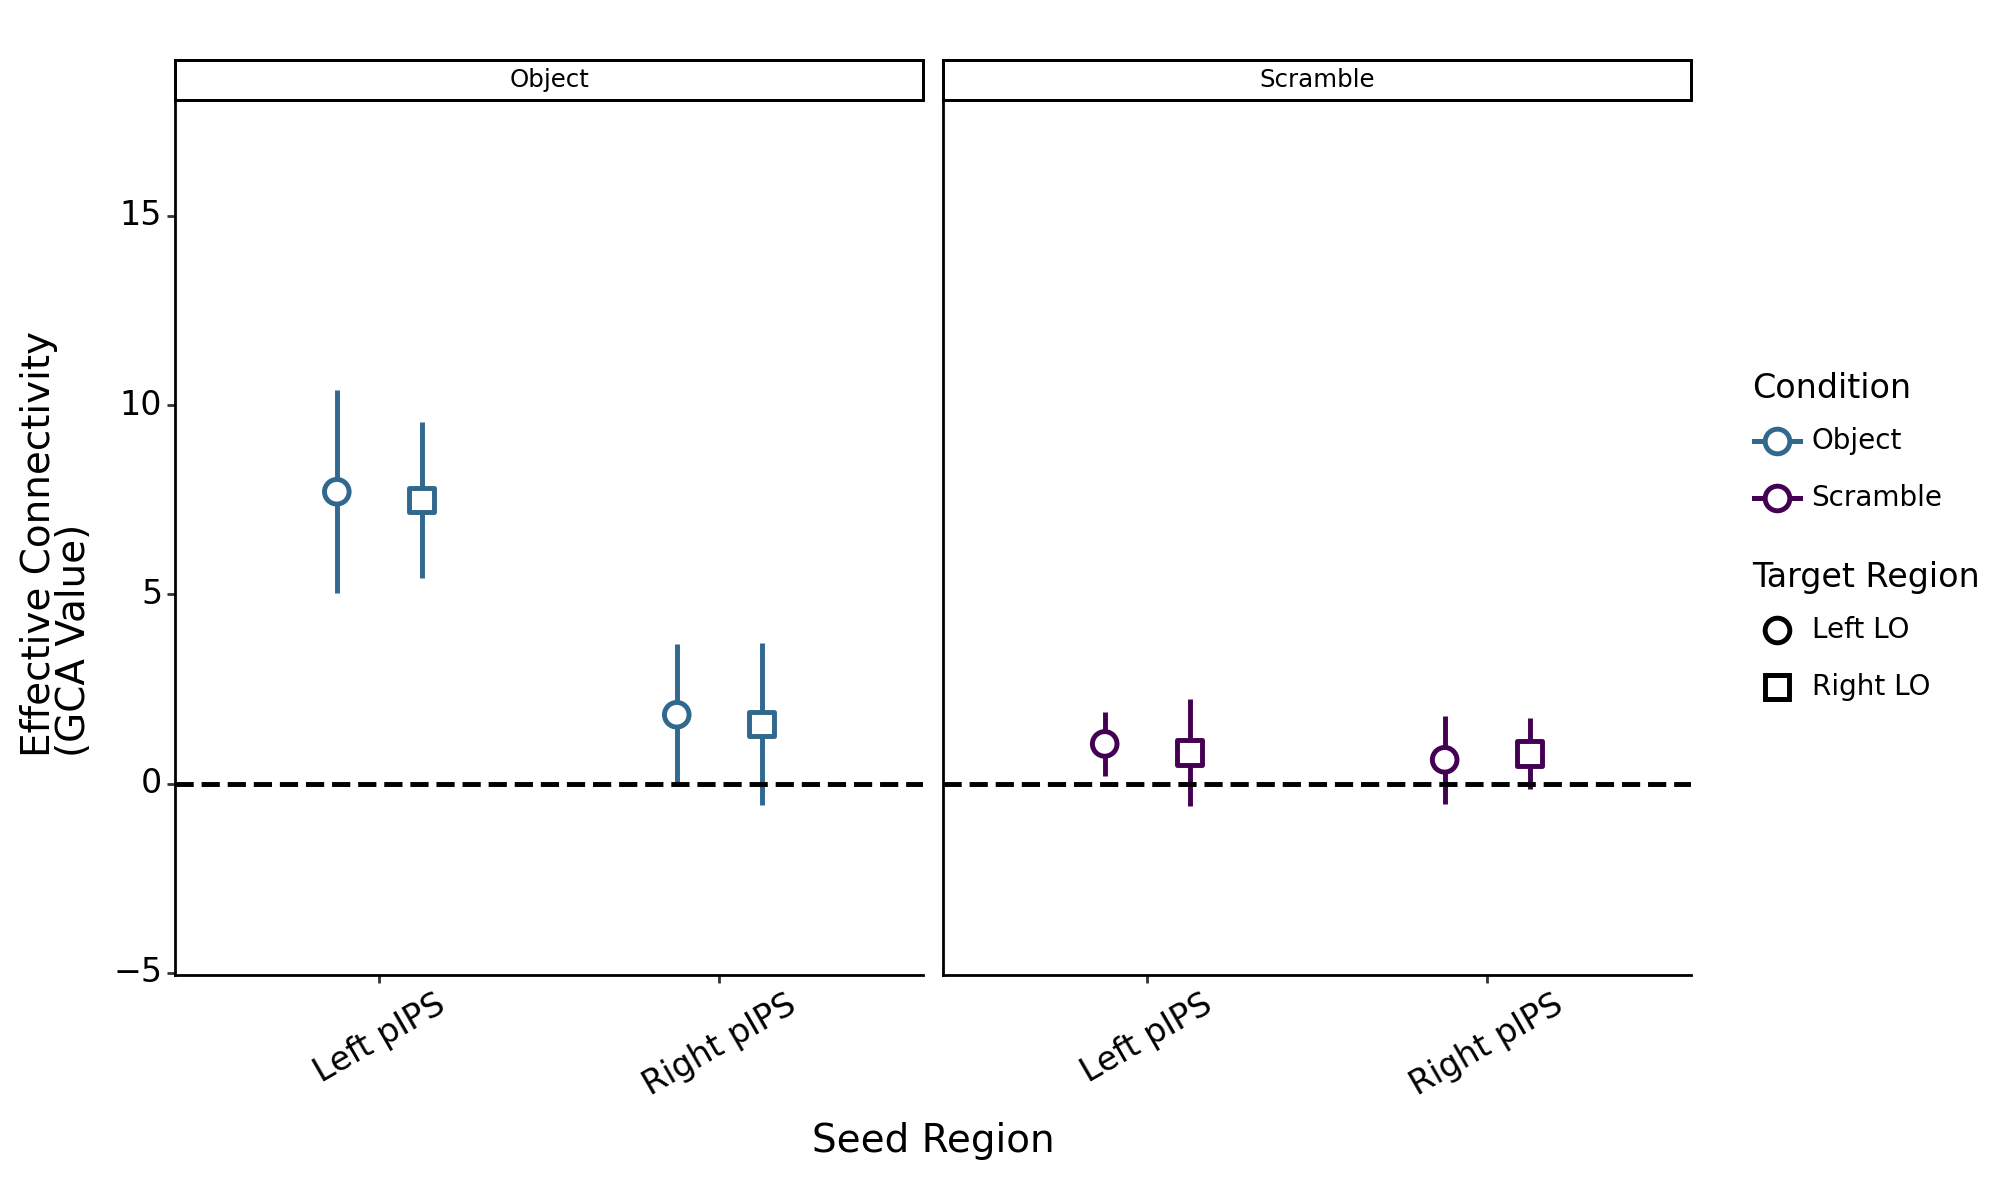

In [ ]:
# Experiment 1 GCA plot

# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, 
                    ylim, xlab, ylab, theme, element_text, element_line, 
                    element_blank, scale_color_manual, position_dodge2, 
                    geom_hline, scale_shape_manual, labs, facet_wrap)

# Read the summary table
summary_table_combined = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Create a plotting dataframe
plot_df = pd.DataFrame({
   'ROI': ['Left pIPS' if 'lpIPS' in x else 'Right pIPS' for x in summary_table_combined['origin']],
   'COND': ['Left LO' if 'lLO' in x else 'Right LO' for x in summary_table_combined['target']],
   'condition': summary_table_combined['condition'],
   'GC': summary_table_combined['Mean f_diff'],
   'SE': summary_table_combined['Std f_diff']/np.sqrt(19)  # Using n=19 subjects
})

# Make categorical variables
plot_df['ROI'] = pd.Categorical(plot_df['ROI'], categories=['Left pIPS', 'Right pIPS'], ordered=False)
plot_df['COND'] = pd.Categorical(plot_df['COND'], categories=['Left LO', 'Right LO'], ordered=False)
plot_df['condition'] = pd.Categorical(plot_df['condition'], categories=['Object', 'Scramble'], ordered=False)

# Create the plot
plot = (ggplot(plot_df, aes(x='ROI', y='GC', color='condition', shape='COND'))
       + geom_linerange(aes(ymin='GC - SE', ymax='GC + SE'), 
                       size=1, position=position_dodge2(width=0.5))
       + geom_point(size=4, fill='white', stroke=1, 
                   position=position_dodge2(width=0.5))
       + ylim(-4, 17)
       + scale_color_manual(values=['#31688E', '#440154'])
       + scale_shape_manual(values=['o', 's'])
       + theme_classic()
       + labs(color='Condition', shape='Target Region')
       + xlab('Seed Region')
       + ylab('Effective Connectivity \n(GCA Value)')
       + geom_hline(yintercept=0, linetype='dashed', size=1)
       + theme(
           text=element_text(color='black'),
           axis_text_x=element_text(angle=30, size=12),
           axis_text_y=element_text(size=12),
           axis_title=element_text(size=14),
           axis_line=element_line(),
           panel_border=element_blank(),
           legend_position="right",
           legend_box="vertical",
           legend_title=element_text(size=12),
           legend_text=element_text(size=10),
           figure_size=(10, 6)
       )
       + facet_wrap('~ condition'))

print(plot)

In [ ]:
## QUICK TRIAL
# Simplified GCA Extraction Script for Experiment 2
# Simplified GCA Extraction Script for Experiment 2
# Handles both tool and non-tool conditions with minimal processing

import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import maskers
import os
from scipy import stats

def get_roi_pairs():
    """Define all ROI pairs for analysis"""
    seeds = ['pIPS_left', 'pIPS_right']
    targets = ['LO_left', 'LO_right']
    pairs = []
    
    for seed in seeds:
        for target in targets:
            pairs.append((seed, target))  # pIPS → LO
            
    return pairs

def get_searchlight_values(subject_id, run_combo, seed_roi, target_roi, condition):
    """Extract values from searchlight maps using ROI coordinates"""
    try:
        # First check if we have a specific coordinates file for this condition
        coords_file = f'tools/roi_coordinates_{condition}.csv'
        if not os.path.exists(coords_file):
            coords_file = 'tools/roi_coordinates.csv'
            print(f"Using default coordinates file: {coords_file}")
        
        coords_df = pd.read_csv(coords_file)
        
        # Format ROI names to match coordinate file
        seed_prefix = 'l' if 'left' in seed_roi.lower() else 'r'
        seed_name = seed_roi.split('_')[0]
        seed_roi_coord_name = f"{seed_prefix}{seed_name}"
        
        # STRICT MATCHING: Only use exact coordinate matches
        seed_coords = coords_df[
            (coords_df['subject'] == subject_id) &  
            (coords_df['run_combo'] == run_combo) & 
            (coords_df['roi'] == seed_roi_coord_name)
        ]
        
        # If we have condition information, prefer those coordinates
        condition_coords = seed_coords[seed_coords['condition'] == condition]
        if not condition_coords.empty:
            seed_coords = condition_coords
            print(f"Using condition-specific ({condition}) coordinates")
        else:
            print(f"WARNING: No condition-specific coordinates, using general coordinates")
        
        if seed_coords.empty:
            print(f"ERROR: No valid coordinates found for {subject_id}, {seed_roi_coord_name}")
            return None
            
        # Log which coordinates we're using
        print(f"Using coordinates for {subject_id}, {seed_roi_coord_name}: {seed_coords[['x', 'y', 'z']].iloc[0].tolist()}")
        coord = (seed_coords['x'].iloc[0], seed_coords['y'].iloc[0], seed_coords['z'].iloc[0])
        
        # Load corresponding searchlight map
        run_pairs = {0: [1, 2], 1: [2, 1]}
        runs = run_pairs[run_combo]
        
        hemi = 'left' if 'left' in target_roi.lower() else 'right'
        roi = target_roi.split('_')[0]
        
        # Check for both naming patterns
        searchlight_paths = [
            # Pattern 1: with condition in name (with s)
            f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_{condition}_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz',
            
            # Pattern 2: without s in condition
            f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_{condition[:-1]}_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz',
            
            # Pattern 3: condition at end
            f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_runs{runs[0]}{runs[1]}_{roi}_{hemi}_{condition}_1217.nii.gz',
            
            # Pattern 4: condition without s at end
            f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_runs{runs[0]}{runs[1]}_{roi}_{hemi}_{condition[:-1]}_1217.nii.gz',
            
            # Pattern 5: with date format
            f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_{condition}_runs{runs[0]}{runs[1]}_{roi}_{hemi}_20231217.nii.gz',
            
            # Pattern 6: in subfolder
            f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/{condition}/searchlight_result_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz'
        ]
        
        searchlight_path = None
        for path in searchlight_paths:
            if os.path.exists(path):
                searchlight_path = path
                print(f"Found file: {path}")
                break
        
        if searchlight_path is None:
            print(f"No matching files found for {subject_id}, {seed_roi} → {target_roi}, {condition}")
            print(f"Tried: {searchlight_paths}")
            return None
        
        roi_masker = maskers.NiftiSpheresMasker([coord], radius=6)
        values = roi_masker.fit_transform(searchlight_path)
        return values.ravel()[0]
        
    except Exception as e:
        print(f"Error processing {subject_id}, {seed_roi}, {target_roi}: {str(e)}")
        return None

def extract_all_values(conditions=['tools', 'nontools']):
    """Extract GCA values for all subjects and ROI pairs for multiple conditions"""
    # Load subject information
    sub_info = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv')
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
    
    print(f"Processing {len(subjects)} subjects for conditions: {conditions}")
    results = []
    roi_pairs = get_roi_pairs()
    
    # Create a log file to track coordinates used
    log_file = '/user_data/csimmon2/git_repos/ptoc/results/gca/coordinate_extraction_log.txt'
    with open(log_file, 'w') as f:
        f.write("GCA Extraction Coordinates Log\n")
        f.write("==============================\n\n")
    
    for condition in conditions:
        print(f"\nProcessing condition: {condition}")
        
        with open(log_file, 'a') as f:
            f.write(f"\nCONDITION: {condition}\n")
            f.write("=" * 30 + "\n")
        
        for subject_id in subjects:
            print(f"Processing subject {subject_id}")
            
            with open(log_file, 'a') as f:
                f.write(f"\nSubject: {subject_id}\n")
            
            for run_combo in [0, 1]:
                for seed_roi, target_roi in roi_pairs:
                    print(f"  {seed_roi} → {target_roi}, run_combo {run_combo}")
                    
                    values = get_searchlight_values(subject_id, run_combo, seed_roi, target_roi, condition)
                    
                    with open(log_file, 'a') as f:
                        if values is not None:
                            f.write(f"  {seed_roi} → {target_roi}, run_combo {run_combo}: {values:.4f}\n")
                        else:
                            f.write(f"  {seed_roi} → {target_roi}, run_combo {run_combo}: NO DATA\n")
                    
                    if values is not None:
                        results.append({
                            'subject': subject_id,
                            'run_combo': run_combo,
                            'seed_roi': seed_roi,
                            'target_roi': target_roi,
                            'gca_value': values,
                            'condition': condition
                        })
    
    return pd.DataFrame(results)

def save_raw_results(results_df):
    """Save raw results without statistical processing"""
    # Create directory if it doesn't exist
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results/gca'
    os.makedirs(results_dir, exist_ok=True)
    
    # Save all raw results
    raw_file = f"{results_dir}/gca_raw_values_all_conditions.csv"
    results_df.to_csv(raw_file, index=False)
    print(f"Raw results saved to {raw_file}")
    
    # Create subject-by-ROI pair summary tables for each condition
    for condition in results_df['condition'].unique():
        condition_df = results_df[results_df['condition'] == condition]
        
        # Aggregate across run_combos for each subject
        agg_df = condition_df.groupby(['subject', 'seed_roi', 'target_roi'])['gca_value'].mean().reset_index()
        
        # Pivot to create subject x roi_pair format
        pivot_df = pd.pivot_table(
            agg_df, 
            values='gca_value', 
            index='subject',
            columns=['seed_roi', 'target_roi'],
            aggfunc='mean'
        )
        
        # Flatten multi-index columns
        pivot_df.columns = [f"{seed}-{target}" for seed, target in pivot_df.columns]
        
        # Save condition-specific summary
        summary_file = f"{results_dir}/subject_roi_pair_summary_{condition}.csv"
        pivot_df.to_csv(summary_file)
        print(f"Subject-ROI pair summary for {condition} saved to {summary_file}")

def main():
    """Main execution function"""
    print("Starting simplified GCA extraction...")
    
    # Extract GCA values for tool and non-tool conditions
    results_df = extract_all_values(conditions=['tool', 'nontool'])
    
    # Save results without statistical processing
    save_raw_results(results_df)
    
    print("Extraction complete!")
    return results_df

if __name__ == "__main__":
    results_df = main()

In [ ]:
# Experiment 2 extraction and stats [est. 6 hours]
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import maskers
import os
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

def get_roi_pairs():
    """Define all ROI pairs for analysis"""
    seeds = ['pIPS_left', 'pIPS_right']
    targets = ['LO_left', 'LO_right']
    pairs = []
    
    for seed in seeds:
        for target in targets:
            pairs.append((seed, target))  # pIPS → LO
            pairs.append((target, seed))  # LO → pIPS
            
    return pairs

def get_searchlight_values(subject_id, run_combo, seed_roi, target_roi, condition='tools'):
    """Extract values from searchlight maps using ROI coordinates"""
    try:
        coords_df = pd.read_csv('tools/roi_coordinates.csv')
        
        # Format ROI names to match coordinate file
        seed_prefix = 'l' if 'left' in seed_roi.lower() else 'r'
        seed_name = seed_roi.split('_')[0]
        seed_roi_coord_name = f"{seed_prefix}{seed_name}"
        
        # Get seed coordinates
        seed_coords = coords_df[
            (coords_df['subject'] == subject_id) &  
            (coords_df['run_combo'] == run_combo) & 
            (coords_df['roi'] == seed_roi_coord_name) &
            (coords_df['condition'] == condition)
        ]
        
        if seed_coords.empty:
            return None
            
        coord = (seed_coords['x'].iloc[0], seed_coords['y'].iloc[0], seed_coords['z'].iloc[0])
        
        # Load corresponding searchlight map
        run_pairs = {0: [1, 2], 1: [2, 1]}
        runs = run_pairs[run_combo]
        
        hemi = 'left' if 'left' in target_roi.lower() else 'right'
        roi = target_roi.split('_')[0]
        searchlight_path = f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_tool_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz'
        
        if not os.path.exists(searchlight_path):
            return None
        
        roi_masker = maskers.NiftiSpheresMasker([coord], radius=6)
        values = roi_masker.fit_transform(searchlight_path)
        return values.ravel()[0]
        
    except Exception as e:
        print(f"Error processing {subject_id}, {seed_roi}, {target_roi}: {str(e)}")
        return None

def extract_all_values():
    """Extract GCA values for all subjects and ROI pairs"""
    # Load subject information
    sub_info = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv')
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
    
    print(f"Processing {len(subjects)} subjects...")
    results = []
    roi_pairs = get_roi_pairs()
    total_combinations = len(subjects) * len(roi_pairs) * 2  # 2 for run_combos
    current = 0
    
    for subject_id in subjects:
        print(f"\nProcessing subject {subject_id}")
        for run_combo in [0, 1]:
            for seed_roi, target_roi in roi_pairs:
                current += 1
                if current % 10 == 0:  # Print progress every 10 combinations
                    print(f"Progress: {current}/{total_combinations}")
                
                values = get_searchlight_values(subject_id, run_combo, seed_roi, target_roi)
                if values is not None:
                    results.append({
                        'subject': subject_id,
                        'run_combo': run_combo,
                        'seed_roi': seed_roi,
                        'target_roi': target_roi,
                        'gca_value': values
                    })
    
    return pd.DataFrame(results)

def run_gca_stats(results_df):
    """Run statistical analysis matching experiment 1"""
    print("\nRunning statistical analysis...")
    
    # First aggregate values across run_combos for each subject
    agg_df = results_df.groupby(['subject', 'seed_roi', 'target_roi'])['gca_value'].mean().reset_index()
    
    # Create summary table with means and standard deviations
    summary_table = pd.DataFrame()
    for seed in ['pIPS_left', 'pIPS_right']:
        for target in ['LO_left', 'LO_right']:
            data = agg_df[(agg_df['seed_roi'] == seed) & (agg_df['target_roi'] == target)]
            
            # Perform Wilcoxon test
            stat, p_value = stats.wilcoxon(data['gca_value'])
            
            summary_table = pd.concat([summary_table, pd.DataFrame({
                'origin': [seed],
                'target': [target],
                'Mean f_diff': [data['gca_value'].mean()],
                'Std f_diff': [data['gca_value'].std()],
                'p_value': [p_value]
            })])
    
    summary_table = summary_table.reset_index(drop=True)
    
    # Apply FDR correction
    p_values = summary_table['p_value'].values
    rejected, p_corrected = fdrcorrection(p_values, alpha=0.05, method='indep')
    
    summary_table['p_value_fdr'] = p_corrected
    summary_table['significant_fdr'] = rejected
    
    # Calculate Cohen's d
    print("\nCohen's d calculations:")
    for _, row in summary_table.iterrows():
        d = calculate_cohens_d(row['Mean f_diff'], row['Std f_diff'])
        print(f"{row['origin']}-{row['target']}: d = {d:.2f}")
    
    return summary_table

def calculate_cohens_d(mean_diff, std_diff):
    """Calculate Cohen's d as simple standardized mean difference"""
    return abs(mean_diff / std_diff)

def main():
    """Main execution function"""
    print("Starting GCA analysis...")
    
    # Extract GCA values
    print("Extracting GCA values...")
    results_df = extract_all_values()
    
    # Save raw results
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results/gca'
    os.makedirs(results_dir, exist_ok=True)
    results_df.to_csv(f"{results_dir}/gca_raw_values_tool_searchlight.csv", index=False)
    print(f"Raw results saved to {results_dir}/gca_raw_values_tool_searchlight.csv")
    
    # Run statistical analysis
    summary_table = run_gca_stats(results_df)
    
    # Save summary results
    summary_table.to_csv(f"{results_dir}/gca_summary_table_tool_searchlight.csv", index=False)
    print(f"Summary results saved to {results_dir}/gca_summary_table_tool_searchlight.csv")
    
    # Save detailed results
    with open(f"{results_dir}/gca_roi_pair_tool_searchlight_results_fdr.txt", 'w') as f:
        f.write("GCA ROI Pair Tool Searchlight Results (Wilcoxon tests):\n\n")
        for _, row in summary_table.iterrows():
            f.write(f"{row['origin']}-{row['target']}:\n")
            f.write(f"p_fdr = {row['p_value_fdr']:.4f}\n")
            f.write(f"significant = {row['significant_fdr']}\n\n")
    
    print("Analysis complete!")
    return results_df, summary_table

if __name__ == "__main__":
    results_df, summary_table = main()

Starting GCA analysis...
Extracting GCA values...


Processing 18 subjects...

Processing subject sub-spaceloc1001
Progress: 10/288

Processing subject sub-spaceloc1002
Progress: 20/288
Progress: 30/288

Processing subject sub-spaceloc1003
Progress: 40/288

Processing subject sub-spaceloc1004
Progress: 50/288
Progress: 60/288

Processing subject sub-spaceloc1005
Progress: 70/288
Progress: 80/288

Processing subject sub-spaceloc1006
Progress: 90/288

Processing subject sub-spaceloc1007
Progress: 100/288
Progress: 110/288

Processing subject sub-spaceloc1008
Progress: 120/288

Processing subject sub-spaceloc1009
Progress: 130/288
Progress: 140/288

Processing subject sub-spaceloc1010
Progress: 150/288
Progress: 160/288

Processing subject sub-spaceloc1011
Progress: 170/288

Processing subject sub-spaceloc1012
Progress: 180/288
Progress: 190/288

Processing subject sub-spaceloc2013
Progress: 200/288

Processing subject sub-spaceloc2014
Progress: 210/288
Progress: 220/288

Processing subject sub-spaceloc2015
Progress: 230/288
Progress: 240/

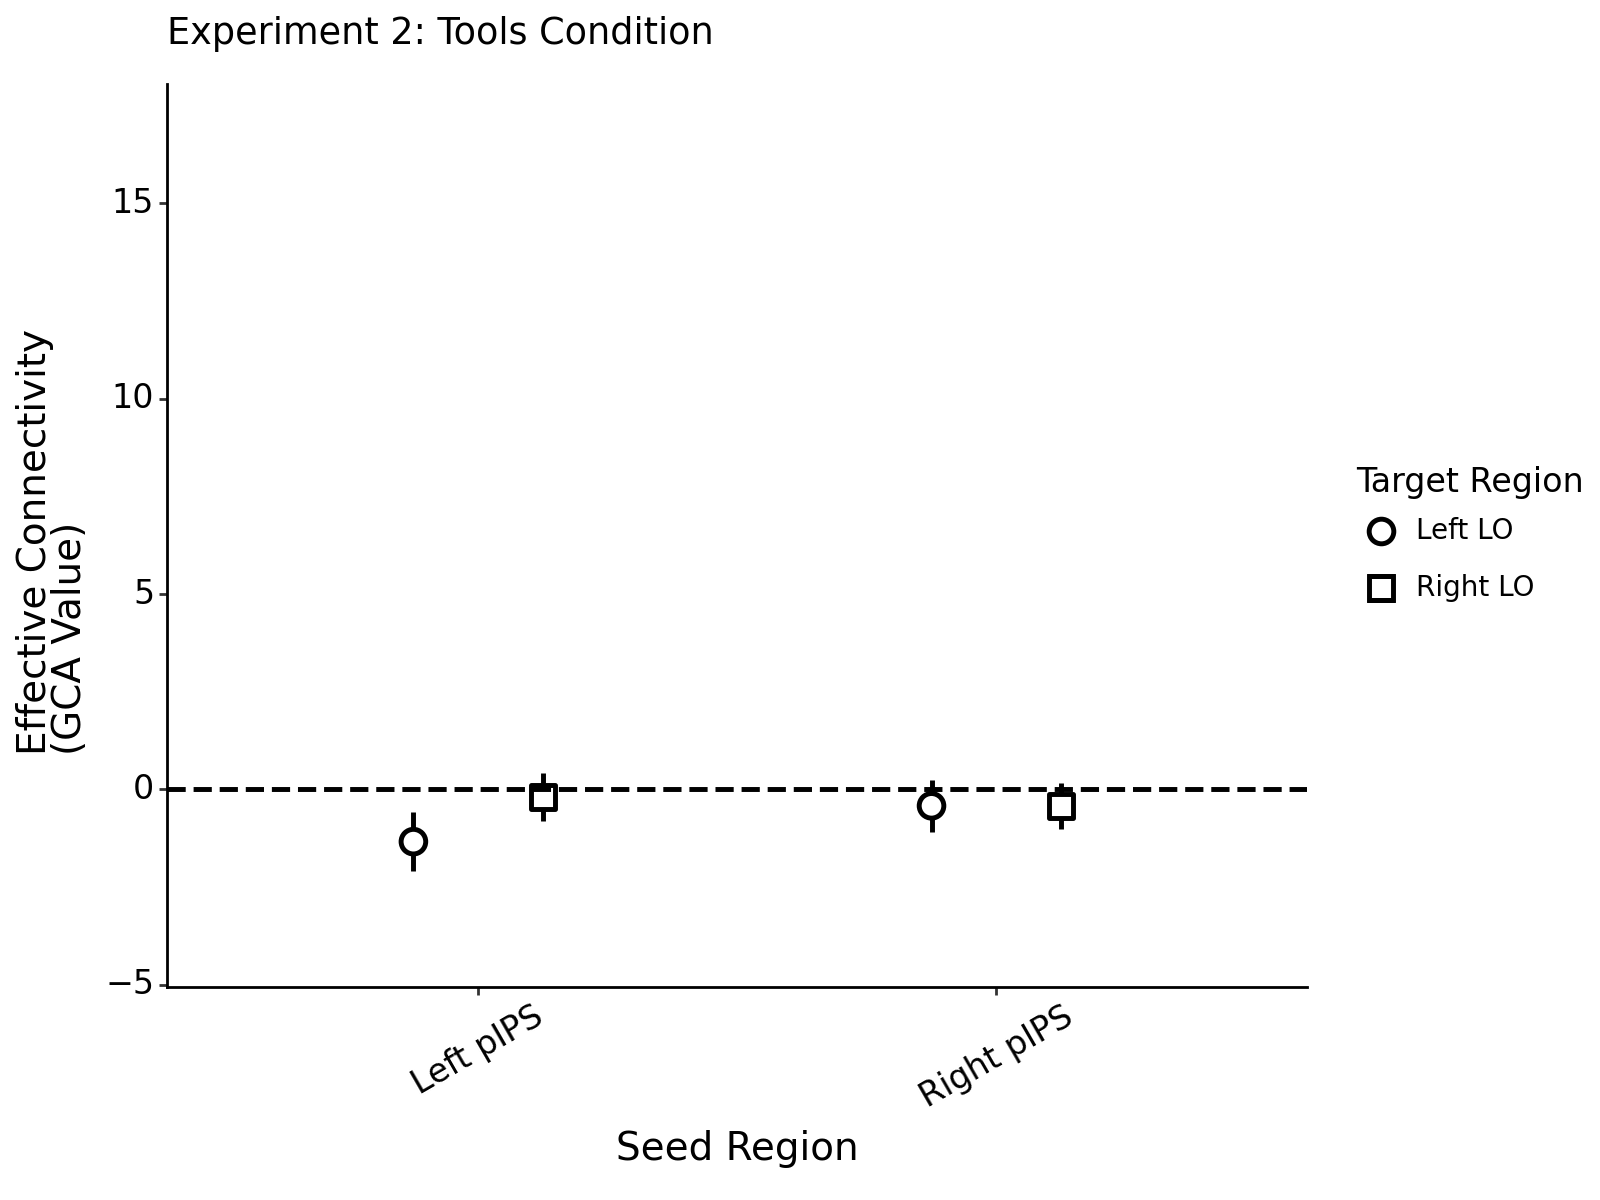

In [ ]:
# Experiment 2 GCA plot

# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, 
                    ylim, xlab, ylab, theme, element_text, element_line, 
                    element_blank, scale_color_manual, position_dodge2, 
                    geom_hline, scale_shape_manual, labs)

# Read the summary table
summary_table = pd.read_csv(f"{fig_dir}/gca_summary_table_tool_searchlight.csv")

# Filter to include only pIPS to LO connections (matching Experiment 1 plot)
summary_table = summary_table[summary_table['origin'].str.contains('pIPS')]

# Create a plotting dataframe
plot_df = pd.DataFrame({
   'ROI': ['Left pIPS' if 'left' in x else 'Right pIPS' for x in summary_table['origin']],
   'COND': ['Left LO' if 'left' in x else 'Right LO' for x in summary_table['target']],
   'condition': ['Tools'] * len(summary_table),  # Only one condition in Experiment 2
   'GC': summary_table['Mean f_diff'],
   'SE': summary_table['Std f_diff']/np.sqrt(19)  # Using n=19 subjects
})

# Make categorical variables
plot_df['ROI'] = pd.Categorical(plot_df['ROI'], categories=['Left pIPS', 'Right pIPS'], ordered=False)
plot_df['COND'] = pd.Categorical(plot_df['COND'], categories=['Left LO', 'Right LO'], ordered=False)

# Create the plot
plot = (ggplot(plot_df, aes(x='ROI', y='GC', shape='COND'))
       + geom_linerange(aes(ymin='GC - SE', ymax='GC + SE'), 
                       size=1, position=position_dodge2(width=0.5))
       + geom_point(size=4, fill='white', stroke=1, 
                   position=position_dodge2(width=0.5))
       + ylim(-4, 17)  # Keeping same scale as Experiment 1 for comparison
       + scale_shape_manual(values=['o', 's'])
       + theme_classic()
       + labs(shape='Target Region', title='Experiment 2: Tools Condition')
       + xlab('Seed Region')
       + ylab('Effective Connectivity \n(GCA Value)')
       + geom_hline(yintercept=0, linetype='dashed', size=1)
       + theme(
           text=element_text(color='black'),
           axis_text_x=element_text(angle=30, size=12),
           axis_text_y=element_text(size=12),
           axis_title=element_text(size=14),
           axis_line=element_line(),
           panel_border=element_blank(),
           legend_position="right",
           legend_title=element_text(size=12),
           legend_text=element_text(size=10),
           figure_size=(8, 6)
       ))

print(plot)